In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime


# Custom modules and packages
import params.siamese
import traversalcost.utils
from dataset import SiameseNetworkDataset
from model import SiameseNetwork
from loss import SiameseLoss
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.siamese.LEARNING

## Prepare data

In [3]:
# Create a Dataset for training
train_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for testing
test_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_test.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Set the train dataset size
train_size = params.siamese.TRAIN_SIZE/(1-params.siamese.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [4]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [5]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (57164 samples)
15.0 % of the data for validation (12250 samples)
15.0 % of the data for testing (12250 samples)


## GPU?

In [6]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [7]:
# Create a model
nb_input_features = len(train_set[0][0])
model = SiameseNetwork(input_size=nb_input_features).to(device=device)

In [8]:
# Create a loss function
criterion = SiameseLoss(margin=LEARNING_PARAMS["margin"]).to(device=device)

In [9]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the accuracy values
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy = train(model,
                                       device,
                                       train_loader,
                                       optimizer,
                                       criterion,
                                       epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model,
                                      device,
                                      val_loader,
                                      criterion,
                                      epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy

  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.1015598167825732
Validation loss:  0.09154113564485063
Train accuracy:  69.8079210692044
Validation accuracy:  73.0530612244898


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.08711393308352837
Validation loss:  0.08282800668772931
Train accuracy:  74.5871527534812
Validation accuracy:  75.6734693877551


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.08023204108996013
Validation loss:  0.07672316359821707
Train accuracy:  76.65663704429362
Validation accuracy:  77.88571428571429


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.07478763293516583
Validation loss:  0.06950324593344703
Train accuracy:  78.40074172556155
Validation accuracy:  80.34285714285714


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.06901063377108484
Validation loss:  0.06706589196498196
Train accuracy:  80.3722622629627
Validation accuracy:  81.36326530612244


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.06405716249406737
Validation loss:  0.06108133641343253
Train accuracy:  81.876705618921
Validation accuracy:  83.07755102040817


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.05905796701017709
Validation loss:  0.06179463898297399
Train accuracy:  83.3041774543419
Validation accuracy:  82.37551020408164


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.05426587708611083
Validation loss:  0.053371695719154864
Train accuracy:  84.76138828633405
Validation accuracy:  85.20816326530613


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.04974406218610421
Validation loss:  0.04668667507939972
Train accuracy:  86.21859911832622
Validation accuracy:  87.2408163265306


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.04541021314610037
Validation loss:  0.0433976679147842
Train accuracy:  87.6215800153943
Validation accuracy:  88.17959183673469


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.04248582683420288
Validation loss:  0.04086891174665652
Train accuracy:  88.48750962144007
Validation accuracy:  88.66938775510204


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.03914765307942293
Validation loss:  0.036647348698655456
Train accuracy:  89.29745993982226
Validation accuracy:  90.13877551020408


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.034187104425891
Validation loss:  0.03441924162325449
Train accuracy:  90.85088517248619
Validation accuracy:  90.9469387755102


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.03195992603760538
Validation loss:  0.029854693474286858
Train accuracy:  91.63634455251557
Validation accuracy:  92.17142857142858


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.030197728750289688
Validation loss:  0.024235388072459802
Train accuracy:  92.00370862780771
Validation accuracy:  93.53469387755102


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.026551023648085044
Validation loss:  0.04076141722422714
Train accuracy:  93.0463228605416
Validation accuracy:  89.78775510204082


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.024622148708117422
Validation loss:  0.021789384523193196
Train accuracy:  93.49065845637114
Validation accuracy:  94.43265306122449


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.022771258958796628
Validation loss:  0.021683590826190386
Train accuracy:  94.0487019802673
Validation accuracy:  94.2530612244898


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.02144830480428367
Validation loss:  0.01670156618153366
Train accuracy:  94.37233223707229
Validation accuracy:  95.85306122448979


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.01823586060288435
Validation loss:  0.017252980503447663
Train accuracy:  95.31523336365545
Validation accuracy:  95.4530612244898


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.018018175187881128
Validation loss:  0.015239411598789351
Train accuracy:  95.34497236022672
Validation accuracy:  96.30204081632652


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.016529899062401297
Validation loss:  0.009526568777801003
Train accuracy:  95.75607025400602
Validation accuracy:  97.91020408163266


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.014918127416485141
Validation loss:  0.014828867305671642
Train accuracy:  96.17416555874327
Validation accuracy:  96.21224489795918


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.013631600854289145
Validation loss:  0.01571221351332497
Train accuracy:  96.464558113498
Validation accuracy:  95.82857142857142


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.013352389456766764
Validation loss:  0.010875973755901214
Train accuracy:  96.56252186690925
Validation accuracy:  97.21632653061225


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.011842567476775222
Validation loss:  0.01838102613692172
Train accuracy:  96.98761458260444
Validation accuracy:  95.31428571428572


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.012275267912749976
Validation loss:  0.012293260976245316
Train accuracy:  96.86341053810091
Validation accuracy:  96.85714285714286


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.01148436548265418
Validation loss:  0.008175603160149572
Train accuracy:  97.12931215450283
Validation accuracy:  97.83673469387755


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.010736805612379706
Validation loss:  0.011228300201764796
Train accuracy:  97.25701490448535
Validation accuracy:  96.97142857142858


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.011149022433390087
Validation loss:  0.011601020997659361
Train accuracy:  97.12756280176335
Validation accuracy:  96.85714285714286


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.010743151997034782
Validation loss:  0.014271608536849575
Train accuracy:  97.31649289762788
Validation accuracy:  96.23673469387755


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.01027592051965945
Validation loss:  0.011047450408417111
Train accuracy:  97.34973059967813
Validation accuracy:  97.11020408163266


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.00912110883663398
Validation loss:  0.010172014903218951
Train accuracy:  97.6733608564831
Validation accuracy:  97.42857142857143


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.007950124363112836
Validation loss:  0.008048739555912713
Train accuracy:  98.01273528794346
Validation accuracy:  98.09795918367347


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.008665368179696918
Validation loss:  0.00614149486500537
Train accuracy:  97.79231684276817
Validation accuracy:  98.51428571428572


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.007774777377078464
Validation loss:  0.010669853048360286
Train accuracy:  98.04247428451473
Validation accuracy:  97.02857142857142


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.007797865408537305
Validation loss:  0.00833778447607377
Train accuracy:  97.96375341123785
Validation accuracy:  97.87755102040816


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.007672556328547648
Validation loss:  0.00795544980064733
Train accuracy:  98.09320551395983
Validation accuracy:  97.91836734693878


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.007753791574542921
Validation loss:  0.007120962584546457
Train accuracy:  98.11769645231264
Validation accuracy:  98.21224489795918


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0069802546867438215
Validation loss:  0.004540769065594456
Train accuracy:  98.28038625708488
Validation accuracy:  98.93877551020408


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.006911749566094721
Validation loss:  0.006467584627292429
Train accuracy:  98.24015114407669
Validation accuracy:  98.36734693877551


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.006929573597765676
Validation loss:  0.008527766030359393
Train accuracy:  98.31537331187461
Validation accuracy:  97.80408163265307


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.007082695637306644
Validation loss:  0.009800301539750459
Train accuracy:  98.20691344202645
Validation accuracy:  97.37959183673469


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.005970253786738854
Validation loss:  0.00832332399780474
Train accuracy:  98.52529564061297
Validation accuracy:  97.86122448979592


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.005985048395098173
Validation loss:  0.006938064464217557
Train accuracy:  98.52004758239451
Validation accuracy:  98.19591836734693


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.006242406134174874
Validation loss:  0.008420015498510717
Train accuracy:  98.41333706528584
Validation accuracy:  97.90204081632653


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.005726149008282245
Validation loss:  0.005491138840928518
Train accuracy:  98.57252816457911
Validation accuracy:  98.73469387755102


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.005815293976382855
Validation loss:  0.0062877236705389805
Train accuracy:  98.50430340773913
Validation accuracy:  98.35102040816327


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.00565365190415641
Validation loss:  0.004285253970010672
Train accuracy:  98.64075292141908
Validation accuracy:  99.02857142857142


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.005438663765488055
Validation loss:  0.003703434624488485
Train accuracy:  98.64425162689805
Validation accuracy:  99.20816326530613


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0055878078794186015
Validation loss:  0.003597439339500852
Train accuracy:  98.61626198306627
Validation accuracy:  99.18367346938776


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.004317199789983547
Validation loss:  0.004896859475896538
Train accuracy:  98.97312994192148
Validation accuracy:  98.75102040816327


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.004242495530007836
Validation loss:  0.00595017089896525
Train accuracy:  98.94339094535022
Validation accuracy:  98.45714285714286


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.004622969477931225
Validation loss:  0.00799066603697914
Train accuracy:  98.84892589741796
Validation accuracy:  97.91836734693878


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.005143243932504815
Validation loss:  0.005156708342838101
Train accuracy:  98.70372962004059
Validation accuracy:  98.59591836734694


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.004673215957000119
Validation loss:  0.0032866297876050035
Train accuracy:  98.83493107550207
Validation accuracy:  99.18367346938776


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.005831801848719417
Validation loss:  0.013640310935443267
Train accuracy:  98.5602826954027
Validation accuracy:  96.52244897959184


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.005062060670768821
Validation loss:  0.0022716359829549524
Train accuracy:  98.74571408578826
Validation accuracy:  99.48571428571428


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.004107390630415222
Validation loss:  0.00440856977365911
Train accuracy:  98.98537541109789
Validation accuracy:  98.96326530612245


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.004433287898811951
Validation loss:  0.002995007482240908
Train accuracy:  98.93114547617381
Validation accuracy:  99.36326530612244


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0038143295176968945
Validation loss:  0.00344232907203453
Train accuracy:  99.1130781610804
Validation accuracy:  99.24897959183673


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.004501651020895615
Validation loss:  0.007254344709508587
Train accuracy:  98.88741165768666
Validation accuracy:  98.02448979591837


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0040466135645897796
Validation loss:  0.0025158482452146322
Train accuracy:  99.01161570219018
Validation accuracy:  99.4530612244898


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0038028350594751454
Validation loss:  0.001830220547465918
Train accuracy:  99.07109369533272
Validation accuracy:  99.58367346938776


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0034040917311138753
Validation loss:  0.0033743746438024877
Train accuracy:  99.19354838709677
Validation accuracy:  99.21632653061225


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.003755985520638409
Validation loss:  0.0037064013395138318
Train accuracy:  99.06759498985376
Validation accuracy:  99.10204081632654


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0034320668288208627
Validation loss:  0.0040636744573324295
Train accuracy:  99.17255615422293
Validation accuracy:  99.0530612244898


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.003305186805059046
Validation loss:  0.0030622410583115802
Train accuracy:  99.22328738366804
Validation accuracy:  99.29795918367347


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002553779995943976
Validation loss:  0.0019182408383737008
Train accuracy:  99.44020712336436
Validation accuracy:  99.58367346938776


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0035823339495341185
Validation loss:  0.004291371141637986
Train accuracy:  99.14806521587013
Validation accuracy:  98.96326530612245


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0032666758035145016
Validation loss:  0.0038624011237213076
Train accuracy:  99.2162899727101
Validation accuracy:  99.07755102040817


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.003148830698915576
Validation loss:  0.003571285201663462
Train accuracy:  99.23378350010496
Validation accuracy:  99.15918367346939


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.003916684177160363
Validation loss:  0.006987834271664421
Train accuracy:  98.9976208802743
Validation accuracy:  98.17142857142858


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0030299919413640194
Validation loss:  0.0028651027702532397
Train accuracy:  99.27051990763418
Validation accuracy:  99.33877551020409


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0026634116521651045
Validation loss:  0.00424589457543334
Train accuracy:  99.37198236652439
Validation accuracy:  98.88979591836734


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002759569044322842
Validation loss:  0.0026766449494364983
Train accuracy:  99.35099013365055
Validation accuracy:  99.29795918367347


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0031686490333912025
Validation loss:  0.005187804861634504
Train accuracy:  99.23028479462599
Validation accuracy:  98.80816326530612


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0032322797606547074
Validation loss:  0.005411883258299592
Train accuracy:  99.2022951507942
Validation accuracy:  98.63673469387756


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002907856145636147
Validation loss:  0.003529622200100372
Train accuracy:  99.32125113707929
Validation accuracy:  99.14285714285714


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002935939772633765
Validation loss:  0.004592492693821744
Train accuracy:  99.29850955146595
Validation accuracy:  98.85714285714286


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002990558633051596
Validation loss:  0.004966612964077892
Train accuracy:  99.31950178433979
Validation accuracy:  98.8


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002617177827975461
Validation loss:  0.003481754829408601
Train accuracy:  99.35973689734799
Validation accuracy:  99.21632653061225


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.003405410756296593
Validation loss:  0.0028921416317947055
Train accuracy:  99.1760548597019
Validation accuracy:  99.33061224489796


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.003186373660440913
Validation loss:  0.003217109750645856
Train accuracy:  99.24602896928137
Validation accuracy:  99.2408163265306


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002971052892206099
Validation loss:  0.0020009789174461425
Train accuracy:  99.27576796585264
Validation accuracy:  99.60816326530612


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.00235422963736958
Validation loss:  0.001953641626945076
Train accuracy:  99.46994611993563
Validation accuracy:  99.59183673469387


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0022685368054690177
Validation loss:  0.0014231516931128378
Train accuracy:  99.50143446924638
Validation accuracy:  99.68979591836735


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002103292947360033
Validation loss:  0.0031394926118082367
Train accuracy:  99.54691764047303
Validation accuracy:  99.22448979591837


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.001559227176314799
Validation loss:  0.0021341307474358473
Train accuracy:  99.67287103771605
Validation accuracy:  99.59183673469387


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.001766721240371899
Validation loss:  0.004723583753123724
Train accuracy:  99.62388916101042
Validation accuracy:  98.80816326530612


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002021750748799218
Validation loss:  0.0017028127913363278
Train accuracy:  99.51717864390176
Validation accuracy:  99.68163265306123


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.00202881911940356
Validation loss:  0.004484039542338299
Train accuracy:  99.5381708767756
Validation accuracy:  98.9469387755102


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0034634818664649857
Validation loss:  0.003007222624243392
Train accuracy:  99.18655097613883
Validation accuracy:  99.28979591836735


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0020391599924180666
Validation loss:  0.0017028054887002024
Train accuracy:  99.54166958225457
Validation accuracy:  99.65714285714286


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0019154662575772744
Validation loss:  0.0019965873871115036
Train accuracy:  99.58190469526275
Validation accuracy:  99.54285714285714


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002960957498737596
Validation loss:  0.0019197112014808226
Train accuracy:  99.29676019872647
Validation accuracy:  99.51020408163265


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002542148277546869
Validation loss:  0.0022394576008082367
Train accuracy:  99.4087187740536
Validation accuracy:  99.4938775510204


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.00227964888180979
Validation loss:  0.004127407499860662
Train accuracy:  99.47869288363306
Validation accuracy:  98.97142857142858


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.0024093648822982308
Validation loss:  0.0017522592315799557
Train accuracy:  99.44370582884333
Validation accuracy:  99.66530612244898


  0%|          | 0/894 [00:00<?, ?batch/s]

  0%|          | 0/192 [00:00<?, ?batch/s]

Train loss:  0.002288416774435098
Validation loss:  0.000989251647600516
Train accuracy:  99.485690294591
Validation accuracy:  99.83673469387755


### Visualization

Text(0.5, 0, 'Epoch')

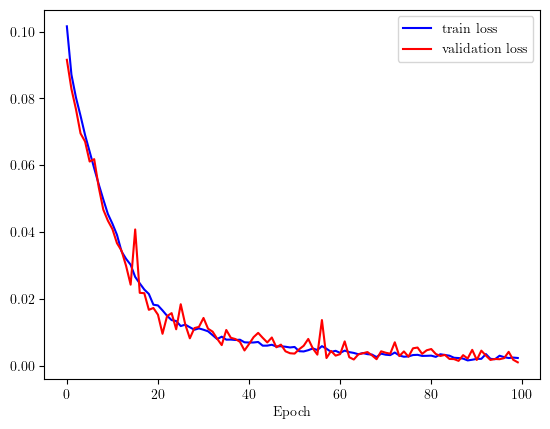

In [10]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

figure = plt.figure()

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

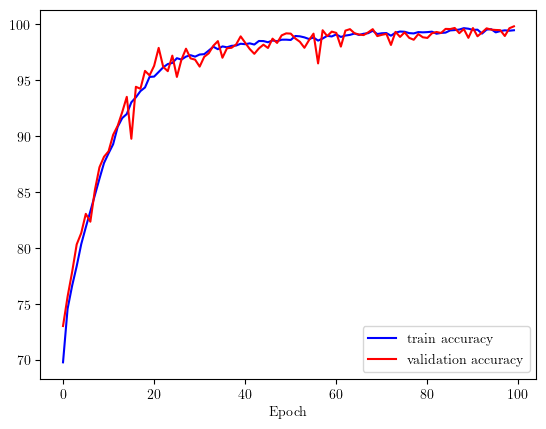

In [11]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [12]:
# Test the model
test_loss, test_accuracy = test(model,
                                device,
                                test_loader,
                                criterion)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

Test loss:  0.0008292473564021444
Test accuracy:  99.88571428571429


## Compute and display traversal costs

In [13]:
# Compute the traversal costs from the features of the dataset
costs_df = traversalcost.utils.compute_traversal_costs(
    dataset=params.siamese.DATASET,
    cost_function=model.to(device="cpu"),
    to_tensor=True
)

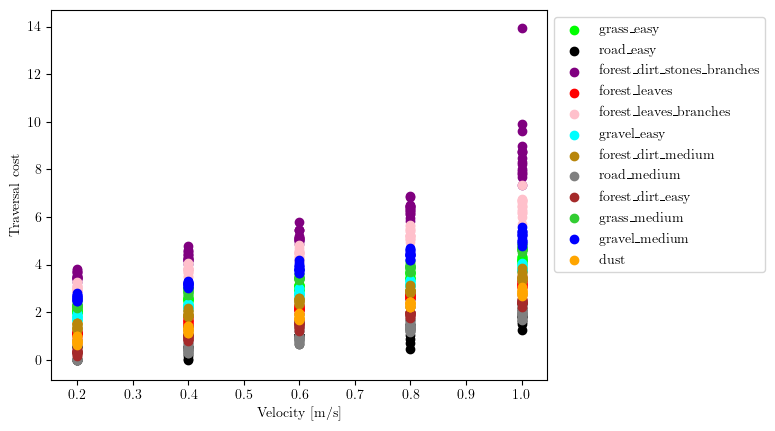

In [14]:
# Display the traversal costs
cost_graph = traversalcost.utils.display_traversal_costs(costs_df)

## Generate a log directory

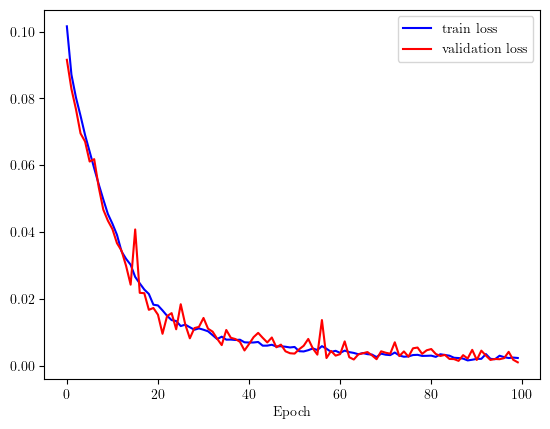

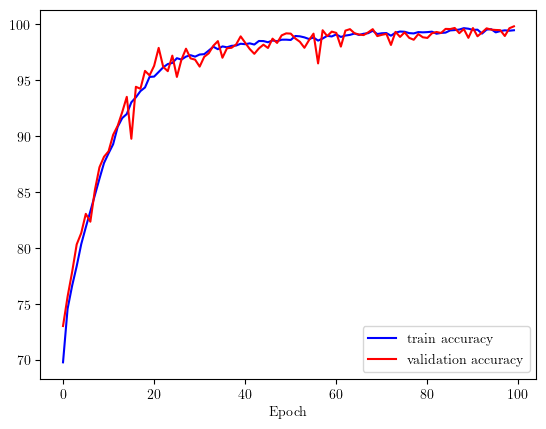

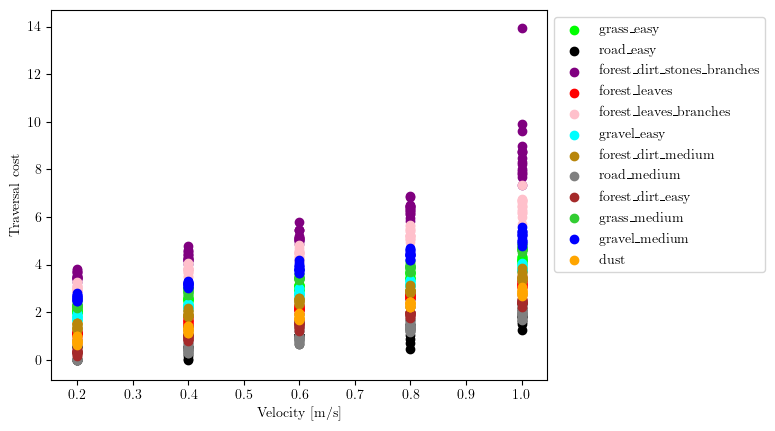

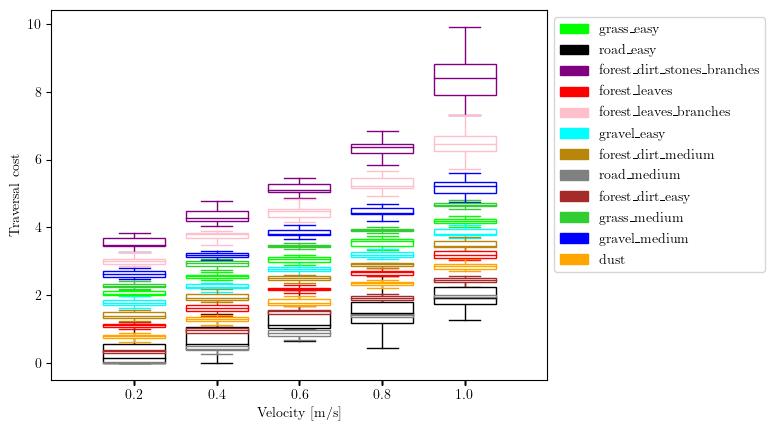

In [15]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.siamese.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.siamese.LOG_DIR:
    results_directory = "logs/_" +\
                        params.siamese.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(dataset_directory=params.siamese.DATASET,
             results_directory=results_directory,
             test_loss=test_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             loss_values=loss_values,
             accuracy_values=accuracy_values)